In [1]:
!wget http://www.soshnikov.com/permanent/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz


--2024-04-20 18:49:55--  http://www.soshnikov.com/permanent/data/petfaces.tar.gz
Resolving www.soshnikov.com (www.soshnikov.com)... 79.137.227.122
Connecting to www.soshnikov.com (www.soshnikov.com)|79.137.227.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24483412 (23M) [application/x-tar]
Saving to: ‘petfaces.tar.gz’

petfaces.tar.gz     100%[===================>]  23.35M   260KB/s    in 93s     

2024-04-20 18:51:30 (256 KB/s) - ‘petfaces.tar.gz’ saved [24483412/24483412]



###Задание № 1

In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 8.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
import time
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision as tv
from torchvision import datasets, models, transforms
import torch.optim as optim
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from collections import defaultdict
import torch.optim as optim
import torchmetrics
import seaborn as sns


%matplotlib inline

In [4]:
def display_images(l,titles=None,fontsize=10):
    n=len(l)
    fig,ax = plt.subplots(1, 2)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*10)
    plt.tight_layout()
    plt.show()

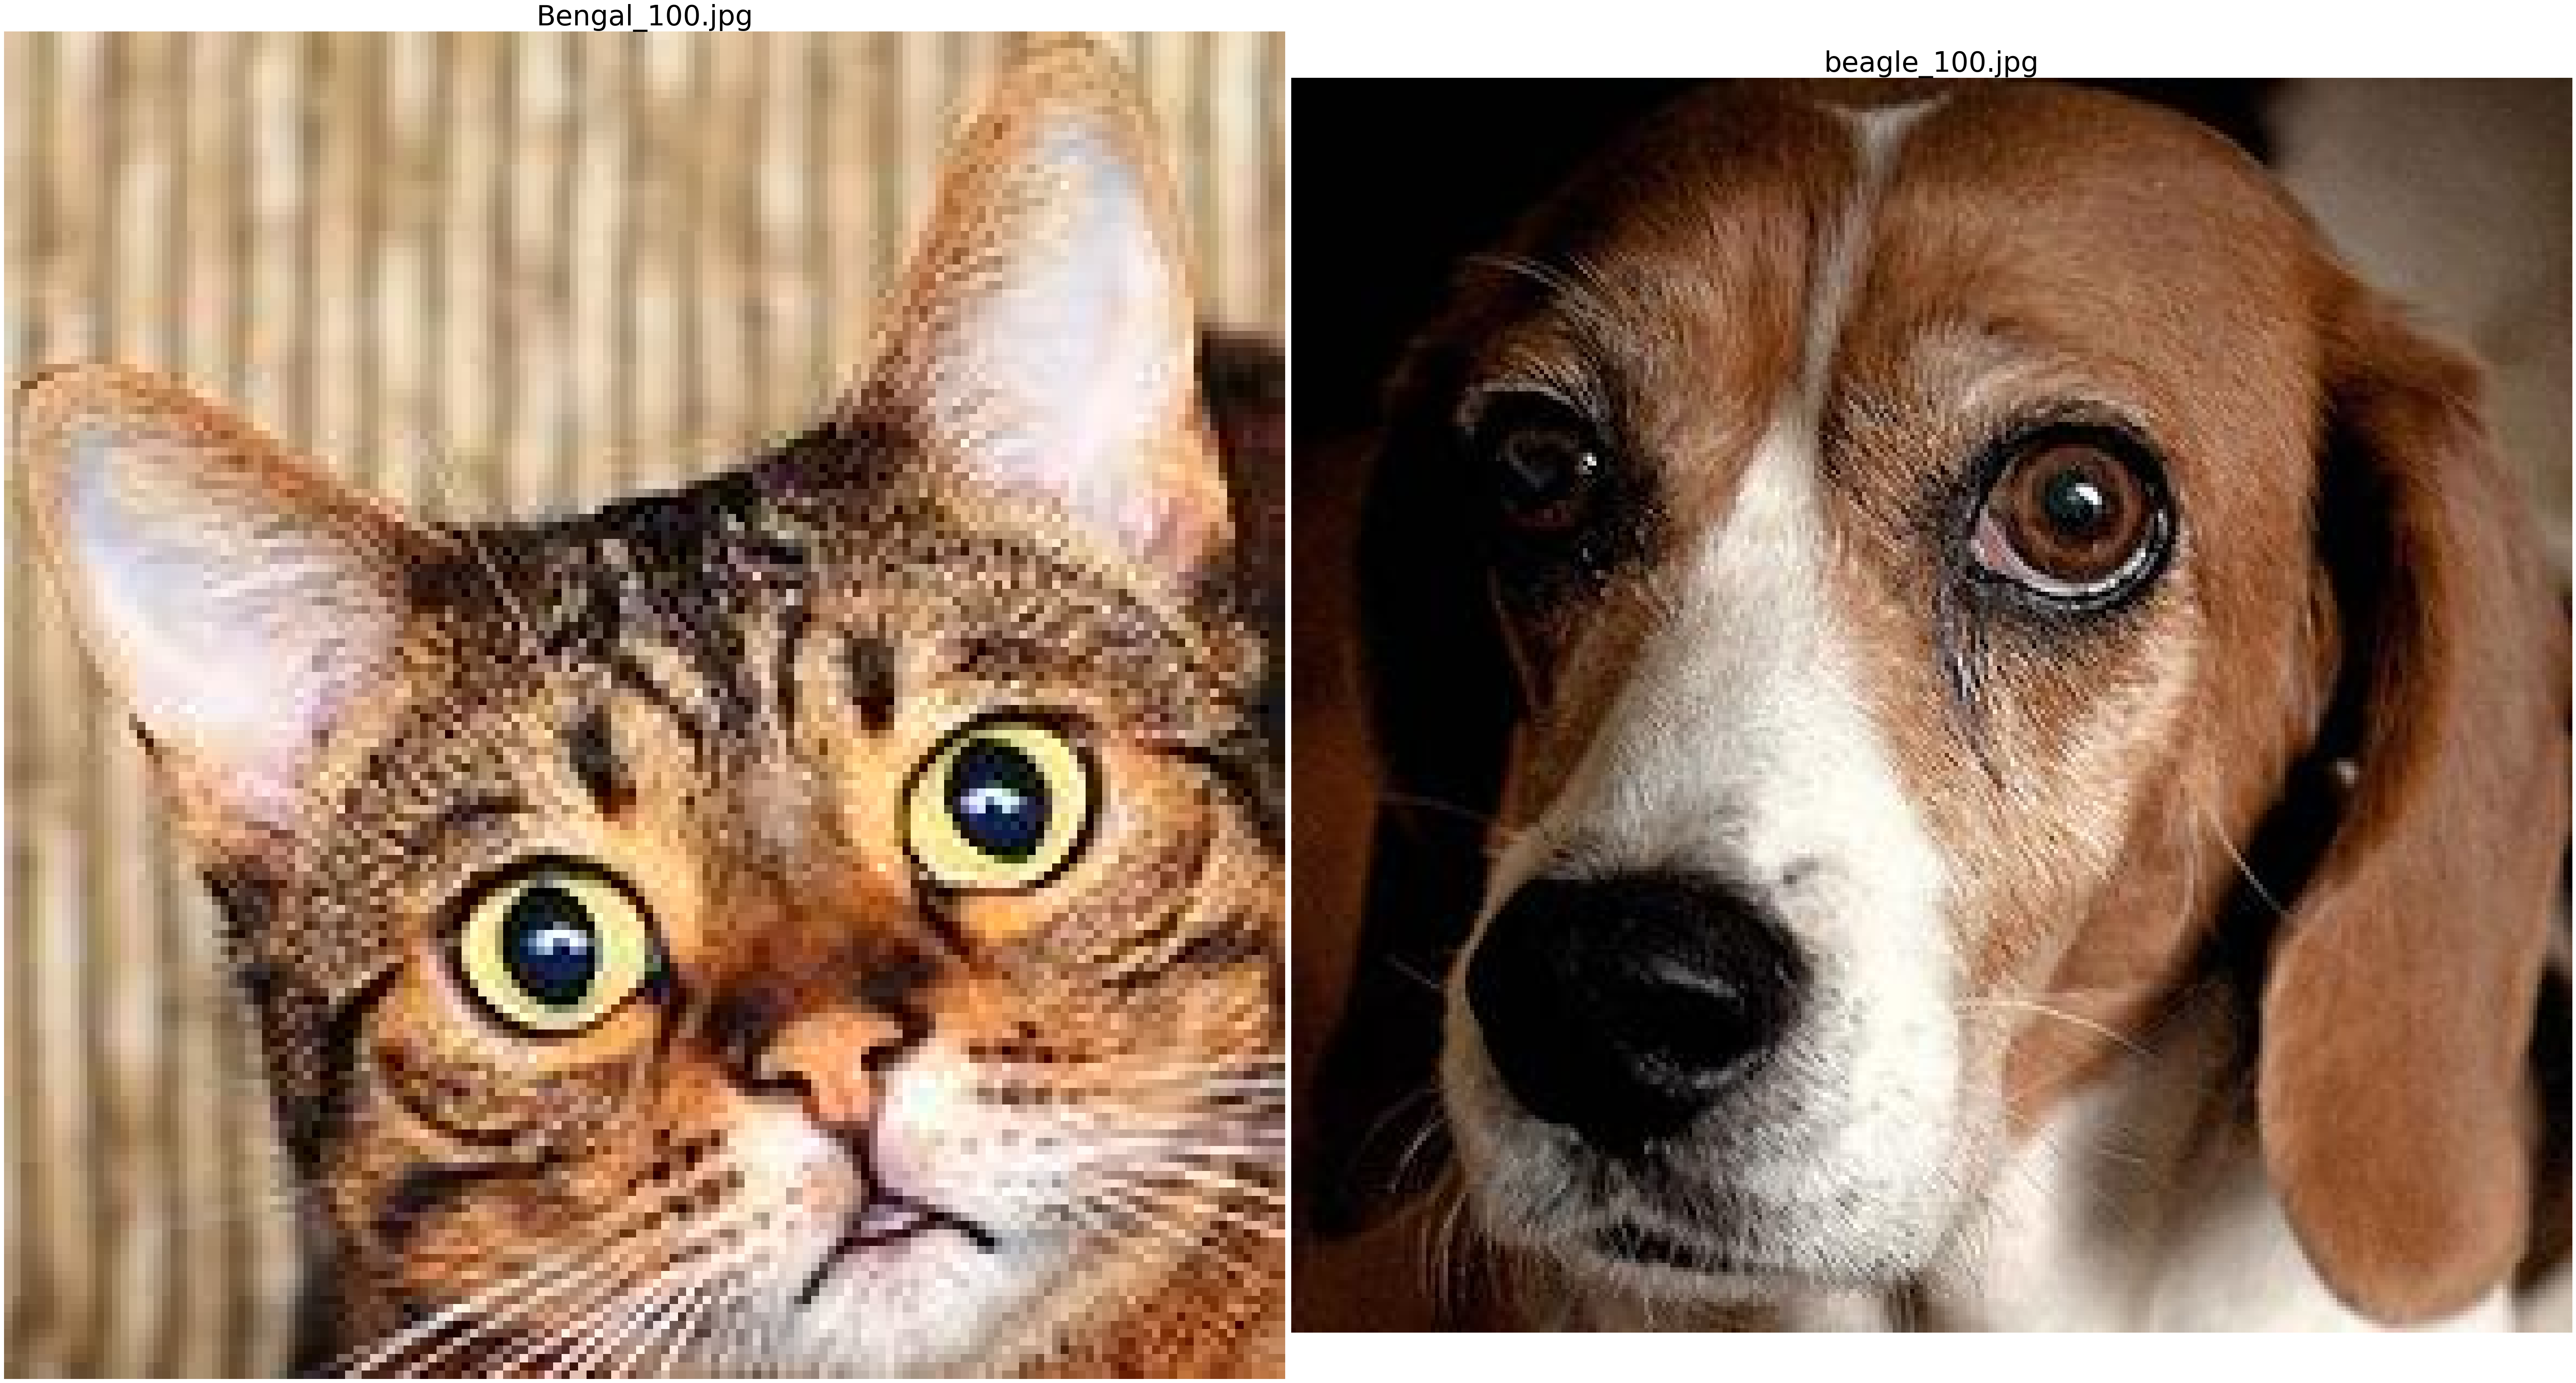

In [ ]:
# Загрузка изображений
image1 = Image.open("petfaces/cat_Bengal/Bengal_100.jpg", "r" )
image2 = Image.open("petfaces/dog_beagle/beagle_100.jpg", "r")

# Отображение изображений
display_images([image1, image2], titles=['Bengal_100.jpg', 'beagle_100.jpg'], fontsize=50)

### 1. Мультиклассовая классификация




In [5]:
# Загрузка и преобразование данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
data = datasets.ImageFolder('petfaces/', transform=transform)

# Разделение данных на train и test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Создание DataLoader'ов для train и test
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [7]:
# Подсчет количества изображений в наборе данных
num_images = len(data)
# Подсчет количества классов в наборе данных
num_classes = len(data.classes)

print(f"Набор данных data содержит {num_images} изображений в {num_classes} классах.")


Набор данных data содержит 3211 изображений в 35 классах.


### 1.1 Model №1

In [ ]:
# Создание нейросети
class MyNet(nn.Module):
    def __init__(self, NUM_CLASSES):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 2, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, NUM_CLASSES)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MyNet(35)

In [ ]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Обучение нейросети
for epoch in range(10):
    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Epoch {epoch}, Iteration {i}, Loss: {loss.item()}')

# Оценка точности на тестовом наборе данных
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        predicted = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total}%')

Epoch 0, Iteration 0, Loss: 3.5707011222839355
Epoch 1, Iteration 0, Loss: 3.514592409133911
Epoch 2, Iteration 0, Loss: 3.554147958755493
Epoch 3, Iteration 0, Loss: 3.523362636566162
Epoch 4, Iteration 0, Loss: 3.4910998344421387
Epoch 5, Iteration 0, Loss: 3.4442944526672363
Epoch 6, Iteration 0, Loss: 3.478076696395874
Epoch 7, Iteration 0, Loss: 3.484834671020508
Epoch 8, Iteration 0, Loss: 3.4388105869293213
Epoch 9, Iteration 0, Loss: 3.4682581424713135
Accuracy on test set: 4.821150855365475%


### 1.2 Model №2

In [ ]:
# Создание нейросети
class MyNet(nn.Module):
    def __init__(self, NUM_CLASSES):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # изменен фильтр с 2Х2 на 3Х3
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # изменен фильтр с 2Х2 на 3Х3
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, NUM_CLASSES)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

model = MyNet(35)  # Заменим NUM_CLASSES на количество классов


In [ ]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# Обучение нейросети
for epoch in range(10):
    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Epoch {epoch}, Iteration {i}, Loss: {loss.item()}')

# Оценка точности на тестовом наборе данных
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        predicted = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total}%')


Epoch 0, Iteration 0, Loss: 3.5509161949157715
Epoch 1, Iteration 0, Loss: 3.4277029037475586
Epoch 2, Iteration 0, Loss: 3.1899375915527344
Epoch 3, Iteration 0, Loss: 3.4847397804260254
Epoch 4, Iteration 0, Loss: 2.602109670639038
Epoch 5, Iteration 0, Loss: 3.037386417388916
Epoch 6, Iteration 0, Loss: 3.353811264038086
Epoch 7, Iteration 0, Loss: 3.047001600265503
Epoch 8, Iteration 0, Loss: 2.4702436923980713
Epoch 9, Iteration 0, Loss: 1.7788115739822388
Accuracy on test set: 20.21772939346812%


### 1.3 Model №3

In [ ]:
# Создание нейросети
class MyNet(nn.Module):
    def __init__(self, NUM_CLASSES):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # изменен фильтр с 2Х2 на 3Х3
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # изменен фильтр с 2Х2 на 3Х3
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, NUM_CLASSES)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

model = MyNet(35)  # Заменим NUM_CLASSES на количество классов

In [ ]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

Epoch 0, Iteration 0, Loss: 3.5620594024658203
Epoch 1, Iteration 0, Loss: 3.775386333465576
Epoch 2, Iteration 0, Loss: 4.400777816772461
Epoch 3, Iteration 0, Loss: 3.3841652870178223
Epoch 4, Iteration 0, Loss: 2.81388783454895
Epoch 5, Iteration 0, Loss: 2.5417373180389404
Epoch 6, Iteration 0, Loss: 1.9990622997283936
Epoch 7, Iteration 0, Loss: 1.9824820756912231
Epoch 8, Iteration 0, Loss: 0.8574894666671753
Epoch 9, Iteration 0, Loss: 0.23379100859165192
Epoch 10, Iteration 0, Loss: 0.03160108998417854
Epoch 11, Iteration 0, Loss: 0.01467775460332632
Epoch 12, Iteration 0, Loss: 0.0008684595813974738
Epoch 13, Iteration 0, Loss: 0.0008896520012058318
Epoch 14, Iteration 0, Loss: 0.0007056117174215615
Epoch 15, Iteration 0, Loss: 0.0006989096291363239
Epoch 16, Iteration 0, Loss: 0.000407909945352003
Epoch 17, Iteration 0, Loss: 0.11241775751113892
Epoch 18, Iteration 0, Loss: 0.0007396630244329572
Epoch 19, Iteration 0, Loss: 0.0005145937320776284
Accuracy on test set: 44.16796

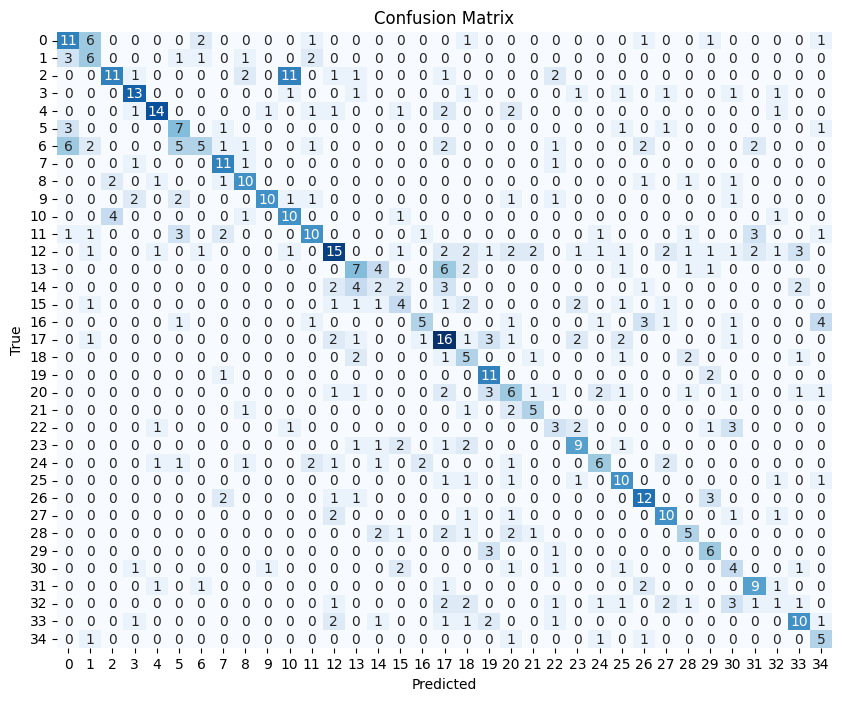

In [ ]:
confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=35, task="multiclass")

# Обучение нейросети
for epoch in range(20):
    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Epoch {epoch}, Iteration {i}, Loss: {loss.item()}')

# Оценка точности на тестовом наборе данных
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        predicted = outputs.argmax(dim=1)  # Получение предсказанных меток
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Обновление confusion_matrix
        confusion_matrix.update(predicted, labels)

print(f'Accuracy on test set: {100 * correct / total}%')

# Получение матрицы в виде массива NumPy
matrix = confusion_matrix.compute().numpy()

# Построение confusion_matrix
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Сохранение модели
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# Оценка top-3 точности на тестовом наборе данных
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        top_3_predictions = torch.topk(outputs, 3, dim=1)[1]  # Получение трех лучших предсказаний
        correct += (top_3_predictions == labels.unsqueeze(-1)).any(dim=1).sum().item()
        total += labels.size(0)

print(f'Top-3 accuracy on test set: {100 * correct / total}%')

Top-3 accuracy on test set: 69.36236391912908%


### 1.4 Model №4

In [ ]:
class MyNet(nn.Module):
    def __init__(self, NUM_CLASSES):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # Добавлен сверточный слой
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 128) # Изменен размер входа для fc1
        self.fc2 = nn.Linear(128, NUM_CLASSES)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) # Изменен вход для следующего слоя conv3
        x = self.pool(F.relu(self.conv3(x))) # Добавлено применение pool перед fc1
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MyNet(35)

In [ ]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

Epoch 0, Iteration 0, Loss: 3.5714423656463623
Epoch 1, Iteration 0, Loss: 3.2063984870910645
Epoch 2, Iteration 0, Loss: 3.793795108795166
Epoch 3, Iteration 0, Loss: 3.0424771308898926
Epoch 4, Iteration 0, Loss: 2.351393222808838
Epoch 5, Iteration 0, Loss: 2.3677611351013184
Epoch 6, Iteration 0, Loss: 2.117421865463257
Epoch 7, Iteration 0, Loss: 4.157713413238525
Epoch 8, Iteration 0, Loss: 0.5992332696914673
Epoch 9, Iteration 0, Loss: 0.5338231921195984
Epoch 10, Iteration 0, Loss: 0.11991354078054428
Epoch 11, Iteration 0, Loss: 0.01001938059926033
Epoch 12, Iteration 0, Loss: 0.007733742240816355
Epoch 13, Iteration 0, Loss: 0.01030333898961544
Epoch 14, Iteration 0, Loss: 0.0032768186647444963
Epoch 15, Iteration 0, Loss: 0.01004369743168354
Epoch 16, Iteration 0, Loss: 0.20525895059108734
Epoch 17, Iteration 0, Loss: 0.2804151773452759
Epoch 18, Iteration 0, Loss: 0.002840588567778468
Epoch 19, Iteration 0, Loss: 0.0008489457541145384
Epoch 20, Iteration 0, Loss: 0.00030039

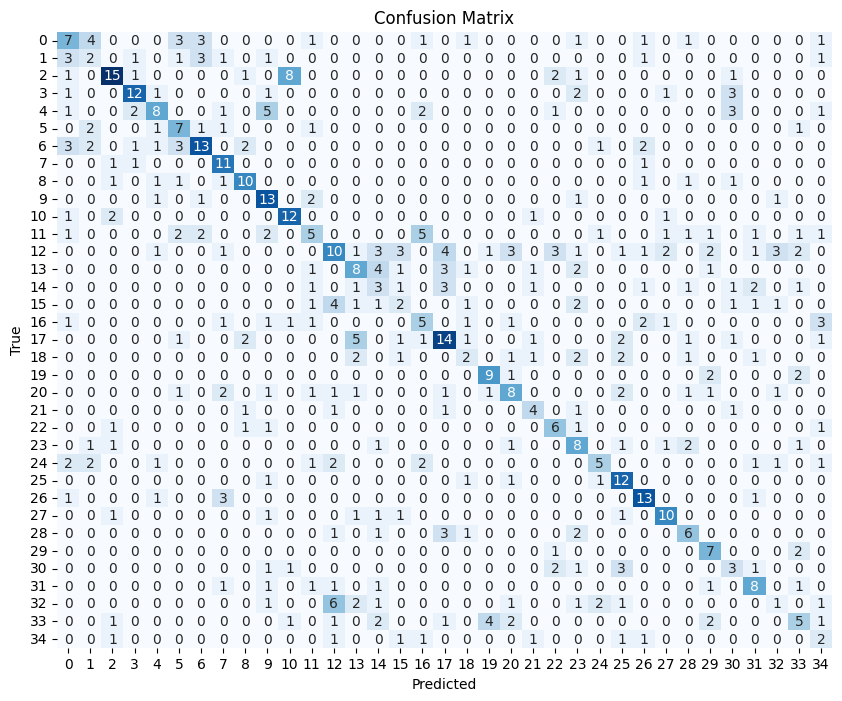

In [ ]:
confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=35, task="multiclass")

# Обучение нейросети
for epoch in range(25):
    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Epoch {epoch}, Iteration {i}, Loss: {loss.item()}')

# Оценка точности на тестовом наборе данных
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        predicted = outputs.argmax(dim=1)  # Получение предсказанных меток
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Обновление confusion_matrix
        confusion_matrix.update(predicted, labels)

print(f'Accuracy on test set: {100 * correct / total}%')

# Получение матрицы в виде массива NumPy
matrix = confusion_matrix.compute().numpy()

# Построение confusion_matrix
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Сохранение модели
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# Оценка top-3 точности на тестовом наборе данных
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        top_3_predictions = torch.topk(outputs, 3, dim=1)[1]  # Получение трех лучших предсказаний
        correct += (top_3_predictions == labels.unsqueeze(-1)).any(dim=1).sum().item()
        total += labels.size(0)

print(f'Top-3 accuracy on test set: {100 * correct / total}%')

Top-3 accuracy on test set: 63.763608087091754%


###1.5 Model №5

In [ ]:
class MyNet(nn.Module):
    def __init__(self, NUM_CLASSES):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.dropout = nn.Dropout(p=0.5) # Добавлен Dropout
        self.fc2 = nn.Linear(128, NUM_CLASSES)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Применение Dropout перед fc2
        x = self.fc2(x)
        return x

model = MyNet(35)

In [ ]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

Epoch 0, Iteration 0, Loss: 3.5653975009918213
Epoch 1, Iteration 0, Loss: 3.415034294128418
Epoch 2, Iteration 0, Loss: 2.9609551429748535
Epoch 3, Iteration 0, Loss: 4.097971439361572
Epoch 4, Iteration 0, Loss: 2.7879421710968018
Epoch 5, Iteration 0, Loss: 2.6904282569885254
Epoch 6, Iteration 0, Loss: 2.9184622764587402
Epoch 7, Iteration 0, Loss: 2.918400764465332
Epoch 8, Iteration 0, Loss: 3.267321825027466
Epoch 9, Iteration 0, Loss: 2.228264808654785
Epoch 10, Iteration 0, Loss: 2.050504684448242
Epoch 11, Iteration 0, Loss: 1.7400214672088623
Epoch 12, Iteration 0, Loss: 1.72541344165802
Epoch 13, Iteration 0, Loss: 0.9048610925674438
Epoch 14, Iteration 0, Loss: 1.0825995206832886
Epoch 15, Iteration 0, Loss: 0.8177482485771179
Epoch 16, Iteration 0, Loss: 1.2790517807006836
Epoch 17, Iteration 0, Loss: 0.5405447483062744
Epoch 18, Iteration 0, Loss: 0.8085453510284424
Epoch 19, Iteration 0, Loss: 0.3290444016456604
Epoch 20, Iteration 0, Loss: 0.23111377656459808
Epoch 21,

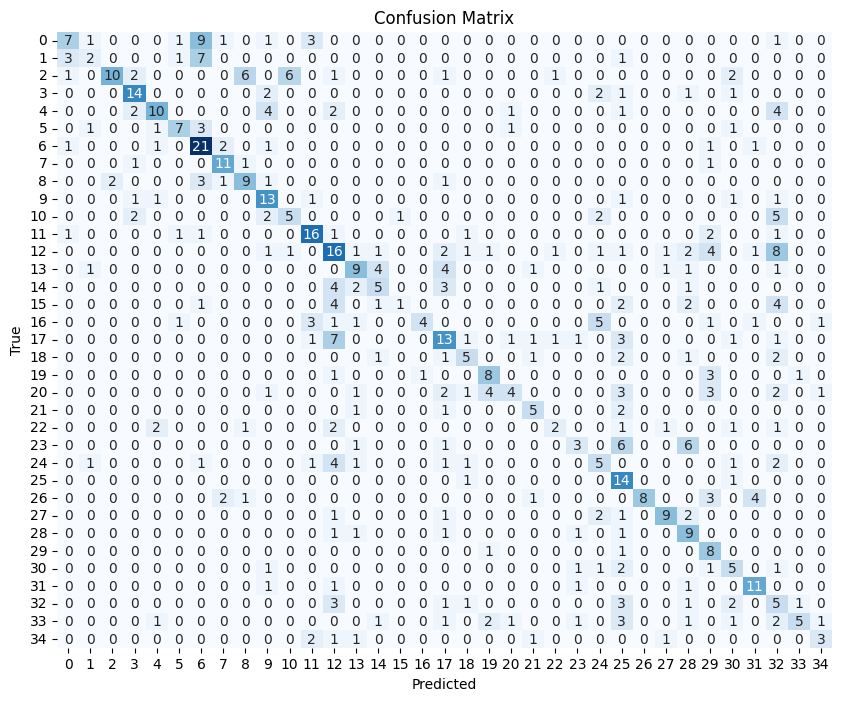

In [ ]:
confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=35, task="multiclass")

# Обучение нейросети
for epoch in range(25):
    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Epoch {epoch}, Iteration {i}, Loss: {loss.item()}')

# Оценка точности на тестовом наборе данных
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        predicted = outputs.argmax(dim=1)  # Получение предсказанных меток
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Обновление confusion_matrix
        confusion_matrix.update(predicted, labels)

print(f'Accuracy on test set: {100 * correct / total}%')

# Получение матрицы в виде массива NumPy
matrix = confusion_matrix.compute().numpy()

# Построение confusion_matrix
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Сохранение модели
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# Оценка top-3 точности на тестовом наборе данных
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        top_3_predictions = torch.topk(outputs, 3, dim=1)[1]  # Получение трех лучших предсказаний
        correct += (top_3_predictions == labels.unsqueeze(-1)).any(dim=1).sum().item()
        total += labels.size(0)

print(f'Top-3 accuracy on test set: {100 * correct / total}%')

Top-3 accuracy on test set: 68.89580093312597%


### 2. Бинарная классификация

In [8]:
!mkdir petfaces/Dog
!mkdir petfaces/Cat
!cp -r petfaces/dog_* petfaces/Dog/
!cp -r petfaces/cat_* petfaces/Cat/
!rm -r petfaces/dog_*
!rm -r petfaces/cat_*

In [9]:
# Загрузка и преобразование данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
data = datasets.ImageFolder('petfaces/', transform=transform)

# Разделение данных на train и test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Создание DataLoader'ов для train и test
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [11]:
# Подсчет количества изображений в наборе данных
num_images = len(data)
# Подсчет количества классов в наборе данных
num_classes = len(data.classes)

print(f"Набор данных data содержит {num_images} изображений в {num_classes} классах.")

Набор данных data содержит 3211 изображений в 2 классах.


### 2.1 Model №1

In [ ]:
# Создание нейросети
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = MyNet()

In [ ]:
# Определение функции потерь и оптимизатора
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# Обучение нейросети
for epoch in range(10):
    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Epoch {epoch}, Iteration {i}, Loss: {loss.item()}')

# Оценка точности на тестовом наборе данных
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        predicted = outputs.round()
        total += labels.size(0)
        correct += (predicted == labels.float().view(-1, 1)).sum().item()

print(f'Accuracy on test set: {100 * correct / total}%')

# Сохранение модели
torch.save(model.state_dict(), 'model_1.pth')

Epoch 0, Iteration 0, Loss: 0.7044017314910889
Epoch 1, Iteration 0, Loss: 0.661983847618103
Epoch 2, Iteration 0, Loss: 0.5971990823745728
Epoch 3, Iteration 0, Loss: 0.5114511847496033
Epoch 4, Iteration 0, Loss: 0.4139363467693329
Epoch 5, Iteration 0, Loss: 0.5078163743019104
Epoch 6, Iteration 0, Loss: 0.3915962278842926
Epoch 7, Iteration 0, Loss: 0.8215926289558411
Epoch 8, Iteration 0, Loss: 0.36617231369018555
Epoch 9, Iteration 0, Loss: 0.3760450482368469
Accuracy on test set: 72.47278382581649%


### 2.2 Model №2

In [ ]:
# Создание нейросети
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # изменен фильтр с 2Х2 на 3Х3
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # изменен фильтр с 2Х2 на 3Х3
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = MyNet()

In [ ]:
# Определение функции потерь и оптимизатора
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
# Обучение нейросети
for epoch in range(10):
    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Epoch {epoch}, Iteration {i}, Loss: {loss.item()}')

# Оценка точности на тестовом наборе данных
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        predicted = outputs.round()
        total += labels.size(0)
        correct += (predicted == labels.float().view(-1, 1)).sum().item()

print(f'Accuracy on test set: {100 * correct / total}%')

# Сохранение модели
torch.save(model.state_dict(), 'model_1.pth')

Epoch 0, Iteration 0, Loss: 0.6880205273628235
Epoch 1, Iteration 0, Loss: 0.6906067132949829
Epoch 2, Iteration 0, Loss: 0.6957881450653076
Epoch 3, Iteration 0, Loss: 0.6887580156326294
Epoch 4, Iteration 0, Loss: 0.6866927146911621
Epoch 5, Iteration 0, Loss: 0.6920472979545593
Epoch 6, Iteration 0, Loss: 0.6919772028923035
Epoch 7, Iteration 0, Loss: 0.690055251121521
Epoch 8, Iteration 0, Loss: 0.6878923177719116
Epoch 9, Iteration 0, Loss: 0.6872539520263672
Accuracy on test set: 56.45412130637636%


### 2.3 Model №3

In [ ]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # Добавлен сверточный слой
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 128) # Изменен размер входа для fc1
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))  # Изменен вход для следующего слоя conv3
        x = self.pool(F.relu(self.conv3(x)))  # Добавлено применение pool перед fc1
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = MyNet()

In [ ]:
# Определение функции потерь и оптимизатора
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
# Обучение нейросети
for epoch in range(10):
    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Epoch {epoch}, Iteration {i}, Loss: {loss.item()}')

# Оценка точности на тестовом наборе данных
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        predicted = outputs.round()
        total += labels.size(0)
        correct += (predicted == labels.float().view(-1, 1)).sum().item()

print(f'Accuracy on test set: {100 * correct / total}%')

# Сохранение модели
torch.save(model.state_dict(), 'model_1.pth')

Epoch 0, Iteration 0, Loss: 0.7024431824684143
Epoch 1, Iteration 0, Loss: 0.660173237323761
Epoch 2, Iteration 0, Loss: 0.501318097114563
Epoch 3, Iteration 0, Loss: 0.4183795750141144
Epoch 4, Iteration 0, Loss: 0.2836887836456299
Epoch 5, Iteration 0, Loss: 0.16335350275039673
Epoch 6, Iteration 0, Loss: 0.6775421500205994
Epoch 7, Iteration 0, Loss: 0.1182151734828949
Epoch 8, Iteration 0, Loss: 0.2789854109287262
Epoch 9, Iteration 0, Loss: 0.09631253033876419
Accuracy on test set: 87.86936236391912%


Accuracy on test set: 87.86936236391912%
Confusion Matrix:
[[219  27]
 [ 51 346]]


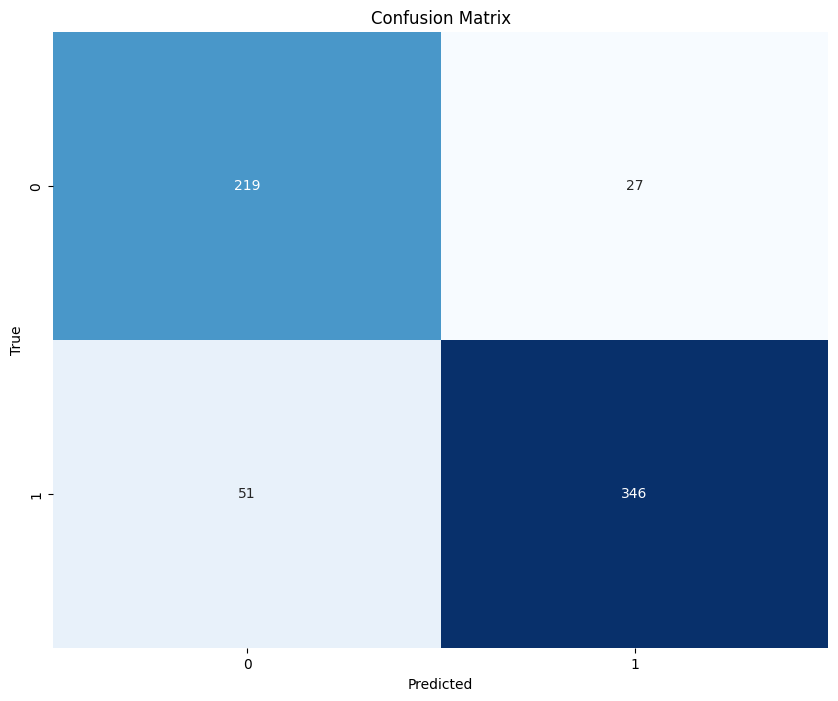

In [ ]:
from sklearn.metrics import confusion_matrix

# Оценка точности на тестовом наборе данных
model.eval()
correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        predicted = outputs.round()
        total += labels.size(0)
        correct += (predicted == labels.float().view(-1, 1)).sum().item()
        true_labels.extend(labels.int())
        predicted_labels.extend(predicted.int().view(-1))

print(f'Accuracy on test set: {100 * correct / total}%')

# Рассчитываем confusion_matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Построение confusion_matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
top3_correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        outputs = outputs.view(-1)  # Преобразовать в одномерный тензор
        _, top3_indices = torch.topk(outputs, k=3, dim=0, largest=True, sorted=True)

        total += labels.size(0)

        for i in range(len(labels)):
            if i >= len(top3_indices):
                top3_correct += 1
            elif torch.tensor(true_labels[i]).item() in top3_indices[i]:
                top3_correct += 1

top3_accuracy = top3_correct * 100 / total

print(f'Top-3 Accuracy: {top3_accuracy}%')


<ipython-input-33-3c64ab7043da>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  elif torch.tensor(true_labels[i]).item() in top3_indices[i]:


Top-3 Accuracy: 90.625%
